# Computational Cognitive Neuroscience
## Assignment 3: Recurrent Neural Networks

In this assignment, a recurrent neural network should be implemented which sums a previous number with a current number. The current number is fed to the network as input.

In [2]:
%matplotlib inline

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.datasets import TupleDataset
from chainer.functions.evaluation import accuracy
from chainer.functions.loss import softmax_cross_entropy
from chainer import link
from chainer import reporter

import matplotlib.pyplot as plt

global HIDDEN_UNITS
HIDDEN_UNITS = 3

In [3]:
# create toy data - compute sum of the previous and current input
def create_data(n=3000):

    X = np.random.rand(n,1).astype('float32')
    T = np.sum(np.hstack((X[0:-1],X[1:])),axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n,1])

    return TupleDataset(X, T)

The network is declared. It consists of an input layer, an LSTM layer with 3 hidden units and an output layer with 1 unit.

In [4]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, HIDDEN_UNITS)
            self.out = L.Linear(None, 1)
            
    def reset_state(self):
        self.l1.reset_state()
        
    def __call__(self, x):
        h1 = self.l1(x)
        y = self.out(h1)
        return y

A regressor is defined which calculates the loss over the prediction and the label. It consist of a network (predictor) and a loss function. 

In [5]:
class Regressor(link.Chain):

    compute_accuracy = False

    def __init__(self, predictor,
                 lossfun=softmax_cross_entropy.softmax_cross_entropy,
                 accfun=accuracy.accuracy,
                 label_key=-1):
        if not (isinstance(label_key, (int, str))):
            raise TypeError('label_key must be int or str, but is %s' %
                            type(label_key))

        super(Regressor, self).__init__()
        self.lossfun = lossfun
        self.accfun = accfun
        self.y = None
        self.loss = None
        self.accuracy = None
        self.label_key = label_key

        with self.init_scope():
            self.predictor = predictor

    def __call__(self, *args, **kwargs):

        if isinstance(self.label_key, int):
            if not (-len(args) <= self.label_key < len(args)):
                msg = 'Label key %d is out of bounds' % self.label_key
                raise ValueError(msg)
            t = args[self.label_key]
            if self.label_key == -1:
                args = args[:-1]
            else:
                args = args[:self.label_key] + args[self.label_key + 1:]
        elif isinstance(self.label_key, str):
            if self.label_key not in kwargs:
                msg = 'Label key "%s" is not found' % self.label_key
                raise ValueError(msg)
            t = kwargs[self.label_key]
            del kwargs[self.label_key]

        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(*args, **kwargs)
        self.loss = self.lossfun(self.y, t)
        reporter.report({'loss': self.loss}, self)
        return self.loss

A function is declared which trains the network and outputs the accumulated loss over the whole training set.

In [187]:
def compute_loss(data, regressor, optimizer, do_train):
    # loss holds the accumulated loss over all the examples
    loss = 0
    # loss25 holds the accumulated loss over the previous 25 examples
    loss25 = Variable(np.array(0, dtype=np.float32))
    # losses holds the accumulated loss per epoch
    losses = []
    count = 0
    for row in data:
        count += 1
        number = np.array([row[0]])
        label = np.array([row[1]])
        regressor.predictor.reset_state() # make a prediction
        add_loss = regressor(number, label)
        
        loss += add_loss
        loss25 += add_loss
        losses.append(loss.data)
        
        # update the weights after 25 examples
        if do_train and count%25==0:
            loss25.backward()
            optimizer.update()
            loss25 = Variable(np.array(0, dtype=np.float32))
            
    return loss, losses

For question 2: a function is created which computes predictions of the network over the first 100 examples of the test set. 

In [188]:
def compute_predictions(data, model):
    preds = []
    for row in data:
        pred = model(np.array([[row[0]]])).data
        preds.append(pred[0][0])
    return preds

For question 2: a function is created which pulls the labels of the first 100 examples of the test set. 

In [189]:
def get_labels(data):
    labels = []
    for row in data:
        label = row[0][0]
        labels.append(label)
    return labels

The run functions start training of the network and evaluates the network over the test set.

In [190]:
def run(network, regressor, optimizer, train_data, test_data):
    network.reset_state()
    regressor.cleargrads()

    loss_train, losses_train = compute_loss(train_data, regressor, optimizer, True)
    print('training_loss: ' + str(loss_train.data))
    
    # Calculate loss and accuracy
    network.reset_state()
    regressor.cleargrads()
    loss_test, losses_test = compute_loss(test_data, regressor, optimizer, False)

    print('test_loss: ' + str(loss_test.data))
    return losses_train, losses_test

training_loss: 1882.1940918
test_loss: 642.193969727


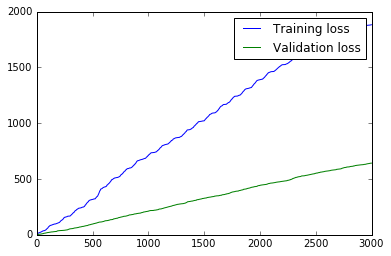

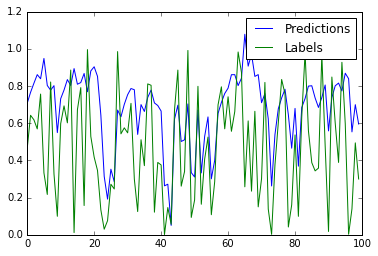

In [192]:
def main():
    # Create data
    train_data = create_data()
    test_data = create_data()

    # Define model
    network = RNN()
    regressor = Regressor(network, F.mean_squared_error)
    optimizer = optimizers.SGD()
    optimizer.setup(regressor)
    
    # Start
    losses_train, losses_test = run(network, regressor, optimizer, train_data, test_data)
    
    plt.figure(1)
    plt.plot(losses_train, label='Training loss')
    plt.plot(losses_test, label='Validation loss')
    plt.legend()
    
    plt.figure(2)
    preds100 = compute_predictions(test_data[:100], network)
    labels100 = get_labels(test_data[:100])
    plt.plot(preds100, label="Predictions")
    plt.plot(labels100, label="Labels")
    plt.legend()

if __name__ == "__main__":
    main()

#### Top plot: question 1
The result of the network seems to be a linearly increasing accumulated loss over the training and test sets. The network therefore does not seem to train efectively.

### Sources
https://docs.chainer.org/en/stable/tutorial/recurrentnet.html